In [1]:
# ===================================================================
# PRASYARAT DAN IMPORT
# ===================================================================
import os
os.environ['MMENGINE_DISABLE_WEIGHTS_ONLY_LOAD'] = '1'

!pip install timm -q
!pip install -U albumentations --no-binary qudida,albumentations -q

import json
import torch
import mmcv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from mmengine.config import Config
from mmengine.runner import Runner
from mmengine.registry import MODELS as MMENGINE_MODELS
from mmengine.dataset import Compose

from mmdet.utils import register_all_modules
from mmdet.registry import MODELS
from mmdet.models.dense_heads import SSDHead
from mmdet.visualization import DetLocalVisualizer
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5060


In [2]:
# ===================================================================
# SEL 1: KONFIGURASI UTAMA
# ===================================================================
# --- Hyperparameters untuk Eksperimen ---
PROJECT_NAME = "BBreadDetector_RetinaNet_ResNet50" 
DATASET_ROOT = 'dataset' # Ganti dengan path ke folder dataset Anda
CLASSES_TO_USE = [
    'baguette', 'cornbread', 'croissant', 'ensaymada', 'flatbread',
    'sourdough', 'wheat-bread', 'white-bread', 'whole-grain-bread', 'pandesal'
]
NUM_CLASSES = len(CLASSES_TO_USE)

# --- Parameter Training ---
BASE_LR = 0.0001
BATCH_SIZE = 4
EPOCHS = 30 # Tingkatkan jumlah epoch untuk hasil yang lebih baik
IMG_SIZE = (512, 512)

# --- Direktori Kerja ---
WORK_DIR = f"outputs/{PROJECT_NAME}"
os.makedirs(WORK_DIR, exist_ok=True)

print(f"Project Name: {PROJECT_NAME}")
print(f"Work Directory: {WORK_DIR}")
print(f"Classes ({NUM_CLASSES}): {CLASSES_TO_USE}")

Project Name: BBreadDetector_RetinaNet_ResNet50
Work Directory: outputs/BBreadDetector_RetinaNet_ResNet50
Classes (10): ['baguette', 'cornbread', 'croissant', 'ensaymada', 'flatbread', 'sourdough', 'wheat-bread', 'white-bread', 'whole-grain-bread', 'pandesal']


In [3]:
# # ===================================================================
# # SEL 2: DEFINISI KELAS KUSTOM (UNTUK MENANGANI ARGUMEN LOSS)
# # ===================================================================
# from mmdet.models.dense_heads import SSDHead
# from mmdet.registry import MODELS
# from mmengine.registry import MODELS as MMENGINE_MODELS
# import torch

# @MODELS.register_module(force=True)
# class CustomSSDHead(SSDHead):
#     def __init__(self, *args, **kwargs):
#         # Logika ini bisa menangani argumen loss_cls dan loss_bbox
#         loss_cls_cfg = kwargs.pop('loss_cls', None)
#         loss_bbox_cfg = kwargs.pop('loss_bbox', None)
#         super().__init__(*args, **kwargs)
#         # Jika didefinisikan, buat objek loss.
#         if loss_cls_cfg:
#             self.loss_cls = MODELS.build(loss_cls_cfg)
#         if loss_bbox_cfg:
#             self.loss_bbox = MODELS.build(loss_bbox_cfg)

# print("CustomSSDHead (untuk menangani loss) berhasil didaftarkan.")

In [4]:
# ===================================================================
# SEL 3: FUNGSI FILTER ANOTASI (Tetap sama)
# ===================================================================
def filter_coco_annotations(original_ann_file, new_ann_file, classes_to_keep):
    if os.path.exists(new_ann_file):
        print(f"File anotasi sudah ada: {new_ann_file}. Melewati pembuatan ulang.")
        return
    with open(original_ann_file, 'r') as f: coco_data = json.load(f)
    original_categories = {cat['name']: cat['id'] for cat in coco_data['categories']}
    new_categories, old_id_to_new_id, new_cat_id = [], {}, 0
    for cat_name in classes_to_keep:
        if cat_name in original_categories:
            new_categories.append({'id': new_cat_id, 'name': cat_name, 'supercategory': 'object'})
            old_id_to_new_id[original_categories[cat_name]] = new_cat_id
            new_cat_id += 1
    new_annotations, image_ids_with_annotations = [], set()
    for ann in coco_data['annotations']:
        if ann.get('iscrowd', 0) == 0 and ann['category_id'] in old_id_to_new_id:
            ann['category_id'] = old_id_to_new_id[ann['category_id']]
            new_annotations.append(ann)
            image_ids_with_annotations.add(ann['image_id'])
    new_images = [img for img in coco_data['images'] if img['id'] in image_ids_with_annotations]
    new_coco_data = {'images': new_images, 'annotations': new_annotations, 'categories': new_categories, 'info': coco_data.get('info', {}), 'licenses': coco_data.get('licenses', [])}
    os.makedirs(os.path.dirname(new_ann_file), exist_ok=True)
    with open(new_ann_file, 'w') as f: json.dump(new_coco_data, f, indent=4)
    print(f"File anotasi baru disimpan di: {new_ann_file}")

original_train_ann, filtered_train_ann = os.path.join(DATASET_ROOT, 'train', '_annotations.coco.json'), os.path.join(DATASET_ROOT, 'train', 'filtered_annotations.coco.json')
original_valid_ann, filtered_valid_ann = os.path.join(DATASET_ROOT, 'valid', '_annotations.coco.json'), os.path.join(DATASET_ROOT, 'valid', 'filtered_annotations.coco.json')
filter_coco_annotations(original_train_ann, filtered_train_ann, CLASSES_TO_USE)
filter_coco_annotations(original_valid_ann, filtered_valid_ann, CLASSES_TO_USE)

File anotasi sudah ada: dataset\train\filtered_annotations.coco.json. Melewati pembuatan ulang.
File anotasi sudah ada: dataset\valid\filtered_annotations.coco.json. Melewati pembuatan ulang.


In [5]:
# ===================================================================
# SEL 4: KONFIGURASI PROFESIONAL (LOAD DARI CLONE - 10 KELAS + MOSAIC)
# ===================================================================

# --- 1. ATUR PATH ANDA DI SINI ---
# Ganti ini dengan path tempat Anda men-clone folder MMDetection
MMDET_FOLDER_PATH = 'mmdetection/' 
# Pastikan path-nya benar!

# Tentukan path file config yang ingin kita gunakan
CONFIG_FILE_PATH = os.path.join(MMDET_FOLDER_PATH, 'configs/retinanet/retinanet_r50_fpn_1x_coco.py')

if not os.path.exists(CONFIG_FILE_PATH):
    print(f"--- ERROR: File config tidak ditemukan di: {CONFIG_FILE_PATH} ---")
    print("--- PASTIKAN 'MMDET_FOLDER_PATH' SUDAH BENAR! ---")
else:
    print(f"--- Berhasil menemukan file config: {CONFIG_FILE_PATH} ---")

# Load file config standar
cfg = Config.fromfile(CONFIG_FILE_PATH)
register_all_modules(init_default_scope=False)
cfg.custom_imports = dict(imports=['mmpretrain.models.backbones.timm_backbone'], allow_failed_imports=False)


# --- 2. MODIFIKASI KONFIGURASI UNTUK DATASET KITA ---

# Set 'load_from' untuk Fine-Tuning (Model pre-trained di COCO)
cfg.load_from = 'https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth'

# Modifikasi "Otak" (Head) untuk 10 kelas kita
cfg.model.bbox_head.num_classes = NUM_CLASSES # NUM_CLASSES dari SEL 1 (akan jadi 10)


# --- 3. DEFINISIKAN ULANG PIPELINE (Kita pakai lagi Mosaic & Albu Anda) ---
albu_train_transforms = [
    dict(type='RandomBrightnessContrast', brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    dict(type='GaussNoise', variance_limit=(10.0, 50.0), p=0.3),
    dict(type='OneOf',
         transforms=[
             dict(type='Blur', blur_limit=3, p=1.0),
             dict(type='MotionBlur', blur_limit=3, p=1.0)
         ], p=0.3),
]

base_train_pipeline = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='LoadAnnotations', with_bbox=True),
]

train_pipeline = [
    dict(type='Mosaic', img_scale=IMG_SIZE, pad_val=114.0),
    dict(type='Resize', scale=IMG_SIZE, keep_ratio=True),
    dict(type='Pad', size=IMG_SIZE, pad_val=dict(img=(114, 114, 114))),
    dict(type='RandomFlip', prob=0.5),
    dict(type='Albu',
         transforms=albu_train_transforms,
         bbox_params=dict(
             type='BboxParams',
             format='pascal_voc',
             label_fields=['gt_bboxes_labels', 'gt_ignore_flags']),
         keymap={'img': 'image', 'gt_bboxes': 'bboxes'}),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackDetInputs')
]

test_pipeline = [
    dict(type='LoadImageFromFile', backend_args=None),
    dict(type='Resize', scale=IMG_SIZE, keep_ratio=True),
    dict(type='Pad', size=IMG_SIZE, pad_val=dict(img=(114, 114, 114))),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='PackDetInputs', meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor'))
]

# --- 4. TIMPA DATALOADER (Menggunakan Mosaic) ---
cfg.train_dataloader = dict(
    batch_size=BATCH_SIZE, 
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dict(
        type='MultiImageMixDataset', # <<< KEMBALI PAKAI MOSAIC
        dataset=dict(
            type='CocoDataset',
            data_root=DATASET_ROOT, 
            ann_file='train/filtered_annotations.coco.json', # File 10-kelas
            data_prefix=dict(img='train/'),
            metainfo=dict(classes=CLASSES_TO_USE), # 10 kelas
            filter_cfg=dict(filter_empty_gt=True, min_size=32),
            pipeline=base_train_pipeline # Pipeline dasar
        ),
        pipeline=train_pipeline # Pipeline augmentasi (Mosaic, etc)
    ))

cfg.val_dataloader = dict(
    batch_size=BATCH_SIZE, 
    num_workers=2,
    persistent_workers=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type='CocoDataset',
        data_root=DATASET_ROOT, 
        ann_file='valid/filtered_annotations.coco.json', # File 10-kelas
        data_prefix=dict(img='valid/'),
        metainfo=dict(classes=CLASSES_TO_USE), # 10 kelas
        test_mode=True,
        filter_cfg=dict(filter_empty_gt=True, min_size=32), # <<< FIX KRUSIAL
        pipeline=test_pipeline
    ))

# --- 5. TIMPA SISA KONFIGURASI ---
cfg.val_evaluator = dict(
    type='CocoMetric',
    ann_file=os.path.join(DATASET_ROOT, 'valid/filtered_annotations.coco.json'),
    metric='bbox')
cfg.test_evaluator = cfg.val_evaluator

# Optimizer & Scheduler (AdamW Anda)
cfg.optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=BASE_LR, weight_decay=0.01))
cfg.param_scheduler = [
    dict(type='LinearLR', start_factor=0.001, by_epoch=False, begin=0, end=500),
    dict(type='CosineAnnealingLR', T_max=EPOCHS, eta_min=BASE_LR * 0.1, by_epoch=True, begin=1, end=EPOCHS)
]

# Setting Training
cfg.train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=EPOCHS, val_interval=10)
cfg.val_cfg = dict(type='ValLoop')
cfg.test_cfg = dict(type='TestLoop')

# Setting Default & Hook
cfg.default_scope = 'mmdet'
cfg.env_cfg = dict(cudnn_benchmark=True)
cfg.log_level = 'INFO'
cfg.log_processor = dict(type='LogProcessor', window_size=50, by_epoch=True)
cfg.resume = False
cfg.work_dir = WORK_DIR 

# Hapus/Timpa hook dari config asli
cfg.default_hooks.timer = dict(type='IterTimerHook')
cfg.default_hooks.logger.interval = 50
cfg.default_hooks.param_scheduler.type = 'ParamSchedulerHook'
cfg.default_hooks.checkpoint = dict(type='CheckpointHook', interval=10, save_best='coco/bbox_mAP', rule='greater')
cfg.default_hooks.sampler_seed = dict(type='DistSamplerSeedHook')
cfg.default_hooks.visualization = dict(type='DetVisualizationHook')

# Hapus visualizer asli (jika ada) dan tambahkan yang baru
cfg.pop('visualizer', None)
cfg.visualizer = dict(
    type='DetLocalVisualizer',
    vis_backends=[dict(type='LocalVisBackend'), dict(type='TensorboardVisBackend')]
)

print(f"\n✅ Konfigurasi PROFESIONAL (Finetune R50, 10 Kelas, Mosaic) telah dibuat.")
print(f"    - Config Asli: {CONFIG_FILE_PATH}")
print(f"    - Kelas      : {NUM_CLASSES} ({CLASSES_TO_USE})")
print(f"    - Checkpoint   : Fine-tuning dari COCO")

--- Berhasil menemukan file config: mmdetection/configs/retinanet/retinanet_r50_fpn_1x_coco.py ---

✅ Konfigurasi PROFESIONAL (Finetune R50, 10 Kelas, Mosaic) telah dibuat.
    - Config Asli: mmdetection/configs/retinanet/retinanet_r50_fpn_1x_coco.py
    - Kelas      : 10 (['baguette', 'cornbread', 'croissant', 'ensaymada', 'flatbread', 'sourdough', 'wheat-bread', 'white-bread', 'whole-grain-bread', 'pandesal'])
    - Checkpoint   : Fine-tuning dari COCO


In [6]:
# ===================================================================
# SEL 5: MULAI TRAINING
# ===================================================================
runner = Runner.from_cfg(cfg)
runner.train()
print(f"\nProses training telah selesai. Semua output disimpan di: {WORK_DIR}")

11/16 02:06:27 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 500773278
    GPU 0: NVIDIA GeForce RTX 5060
    CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.8
    NVCC: Cuda compilation tools, release 12.8, V12.8.61
    MSVC: n/a, reason: fileno
    PyTorch: 2.9.0+cu128
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 201703
  - MSVC 194234444
  - Intel(R) oneAPI Math Kernel Library Version 2025.2-Product Build 20250620 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencod

c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmdet\datasets\transforms\transforms.py:1674: UserWarning: Argument(s) 'variance_limit' are not valid for transform GaussNoise
  return obj_cls(**args)
c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
11/16 02:06:33 - mmengine - INFO - load model from: torchvision://resnet50
11/16 02:06:33 - mmengine - INFO - Loads checkpoint by torchvision backend from path: torchvision://resnet50
11/16 02:06:33 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth
Downloading: "https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth" to C:\Users\Stevenstven/.cache\torch\hub\checkpoints\retinanet_r50_fpn_1x_coco_20200130-c2398f9

In [7]:
# ===================================================================
# SEL 6: SETUP DIREKTORI ANALISIS DAN PENCARIAN PATH (VERSI FINAL ROBUST)
# ===================================================================
latest_run_dir = None
best_checkpoint_path = None
REPORT_DIR = None

if os.path.exists(WORK_DIR):
    # --- Cari subfolder run terbaru untuk LOGS ---
    run_folders = [
        d for d in os.listdir(WORK_DIR)
        if os.path.isdir(os.path.join(WORK_DIR, d)) and d.replace('_', '').isdigit()
    ]
    if run_folders:
        run_folders.sort()
        latest_run_dir = os.path.join(WORK_DIR, run_folders[-1])
        print(f"--- Menganalisis direktori run (untuk log): {latest_run_dir} ---")
        
        # Buat direktori laporan di dalam direktori run
        REPORT_DIR = os.path.join(latest_run_dir, 'post_training_reports')
        os.makedirs(REPORT_DIR, exist_ok=True)
        print(f"Laporan akan disimpan di: {REPORT_DIR}")
    else:
        print(f"--- PERINGATAN: Tidak ada subfolder run yang valid (untuk log) ditemukan di '{WORK_DIR}'.")

    # --- PERBAIKAN UTAMA: Cari checkpoint terbaik di WORK_DIR utama ---
    # Ini terpisah dari pencarian subfolder log
    best_ckpts = [f for f in os.listdir(WORK_DIR) if f.startswith('best_') and f.endswith('.pth')]
    if best_ckpts:
        # Ambil yang terbaru berdasarkan waktu modifikasi
        best_ckpts.sort(key=lambda x: os.path.getmtime(os.path.join(WORK_DIR, x)))
        best_checkpoint_path = os.path.join(WORK_DIR, best_ckpts[-1])
        print(f"Checkpoint terbaik ditemukan di direktori utama: {best_checkpoint_path}")
    else:
        print(f"PERINGATAN: Tidak ada checkpoint terbaik ('best_*.pth') yang ditemukan di {WORK_DIR}.")

# Jika salah satu tidak ditemukan, beri tahu pengguna
if not latest_run_dir or not best_checkpoint_path:
    print("\n--- PERINGATAN: Analisis lengkap tidak dapat dilanjutkan karena log atau checkpoint terbaik tidak ditemukan. ---")

--- Menganalisis direktori run (untuk log): outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625 ---
Laporan akan disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\post_training_reports
Checkpoint terbaik ditemukan di direktori utama: outputs/BBreadDetector_RetinaNet_ResNet50\best_coco_bbox_mAP_epoch_20.pth



>>> Membuat grafik stabilitas training (Loss vs. mAP)...
--- Membaca log dari: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\vis_data\20251116_020625.json ---


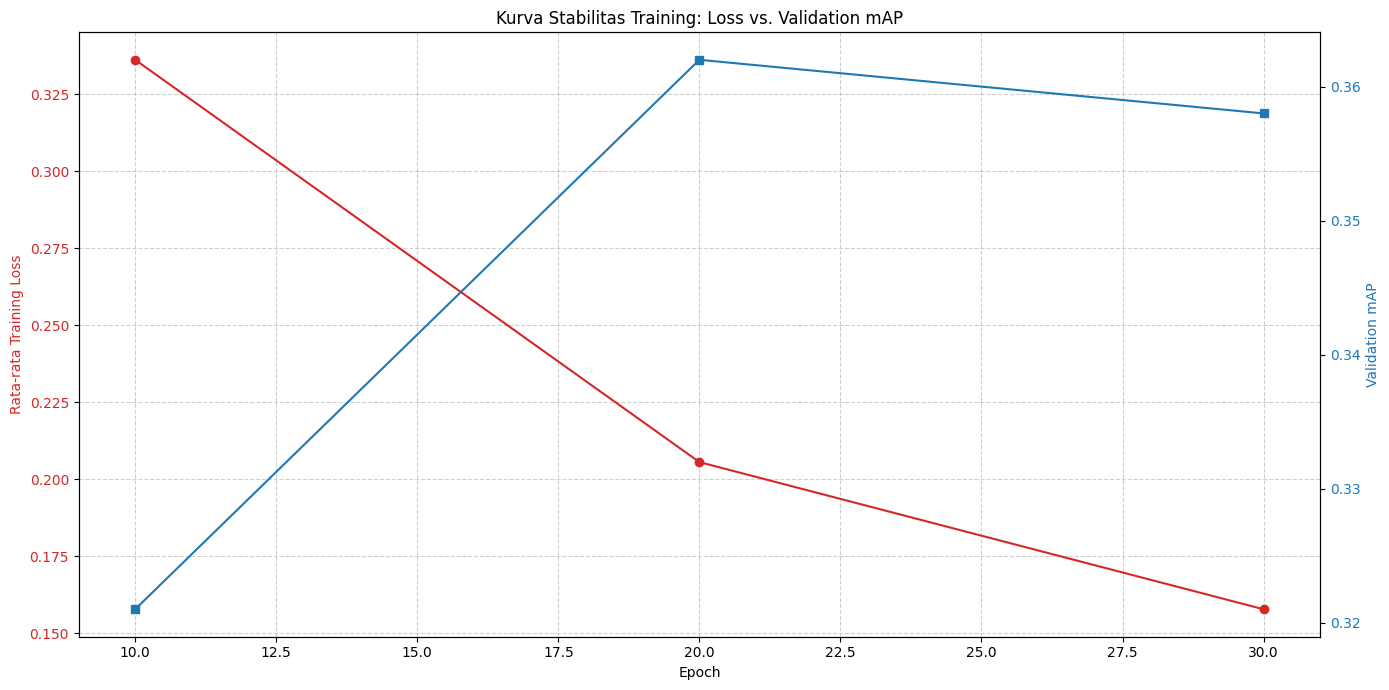

>>> Grafik stabilitas training disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\post_training_reports\training_stability_curve.png


In [8]:
# ===================================================================
# SEL 7: PLOTTING KURVA STABILITAS TRAINING (VERSI PALING ROBUST)
# ===================================================================
def create_stability_curve_by_epoch(run_dir, report_dir):
    print("\n>>> Membuat grafik stabilitas training (Loss vs. mAP)...")
    if not run_dir or not report_dir:
        print("--- PERINGATAN: Direktori run atau laporan tidak valid. Melewati pembuatan grafik.")
        return

    log_file = None
    vis_data_path = os.path.join(run_dir, 'vis_data')

    if os.path.exists(vis_data_path):
        json_logs = [f for f in os.listdir(vis_data_path) if f.endswith('.json') and 'scalars' not in f]
        if json_logs:
            json_logs.sort(key=lambda x: os.path.getmtime(os.path.join(vis_data_path, x)))
            log_file = os.path.join(vis_data_path, json_logs[-1])
    
    if not log_file or not os.path.exists(log_file):
        print(f"--- PERINGATAN: File log .json tidak ditemukan di '{vis_data_path}'. Grafik stabilitas tidak dapat dibuat.")
        return

    print(f"--- Membaca log dari: {log_file} ---")
    log_data = []
    with open(log_file, 'r') as f:
        for line in f:
            try: log_data.append(pd.json_normalize(json.loads(line)))
            except json.JSONDecodeError: continue

    if not log_data:
        print("--- GAGAL: Tidak ada data valid yang bisa dibaca dari file log.")
        return

    log_df = pd.concat(log_data, ignore_index=True)

    # Proses log training
    train_log = log_df[log_df['loss'].notna()][['epoch', 'loss']].groupby('epoch').mean().reset_index()

    # --- PERBAIKAN UTAMA: Isolasi kolom untuk menghindari duplikasi nama ---
    val_log_raw = log_df[log_df['coco/bbox_mAP'].notna()].copy()
    
    if 'step' in val_log_raw.columns and 'coco/bbox_mAP' in val_log_raw.columns:
        # 1. Buat DataFrame baru HANYA dengan kolom yang dibutuhkan
        val_log_subset = val_log_raw[['step', 'coco/bbox_mAP']]
        # 2. Ganti nama kolom di subset yang bersih ini
        val_log_subset = val_log_subset.rename(columns={'step': 'epoch'})
        # 3. Agregasi subset ini (dijamin tidak ada duplikat kolom 'epoch')
        val_log = val_log_subset.groupby('epoch')[['coco/bbox_mAP']].mean().reset_index()
    else:
        print("--- GAGAL: Kolom 'step' atau 'coco/bbox_mAP' tidak ditemukan di log validasi.")
        return
    # --- AKHIR PERBAIKAN ---
    
    # Gabungkan kedua log berdasarkan kolom 'epoch'
    merged_log = pd.merge(train_log, val_log, on='epoch', how='inner')

    if merged_log.empty:
        print("--- GAGAL: Tidak dapat menggabungkan data training loss dan validation mAP. Periksa file log.")
        return

    # Sisa fungsi untuk plotting tidak berubah
    fig, ax1 = plt.subplots(figsize=(14, 7))
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Rata-rata Training Loss', color=color)
    ax1.plot(merged_log['epoch'], merged_log['loss'], 'o-', color=color, label='Training Loss (rata-rata)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation mAP', color=color)
    ax2.plot(merged_log['epoch'], merged_log['coco/bbox_mAP'], 's-', color=color, label='Validation mAP')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Kurva Stabilitas Training: Loss vs. Validation mAP')
    fig.tight_layout()
    plot_path = os.path.join(report_dir, 'training_stability_curve.png')
    plt.savefig(plot_path, dpi=200)
    plt.show()
    print(f">>> Grafik stabilitas training disimpan di: {plot_path}")

# Panggil fungsi dengan variabel yang sudah didefinisikan di SEL 6
create_stability_curve_by_epoch(latest_run_dir, REPORT_DIR)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

>>> Memulai evaluasi kustom (Score Thr: 0.3, IoU Thr: 0.5)...


Mengevaluasi gambar: 100%|██████████| 311/311 [00:09<00:00, 32.86it/s]


>>> Metrik per kelas disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\post_training_reports\per_class_metrics.csv


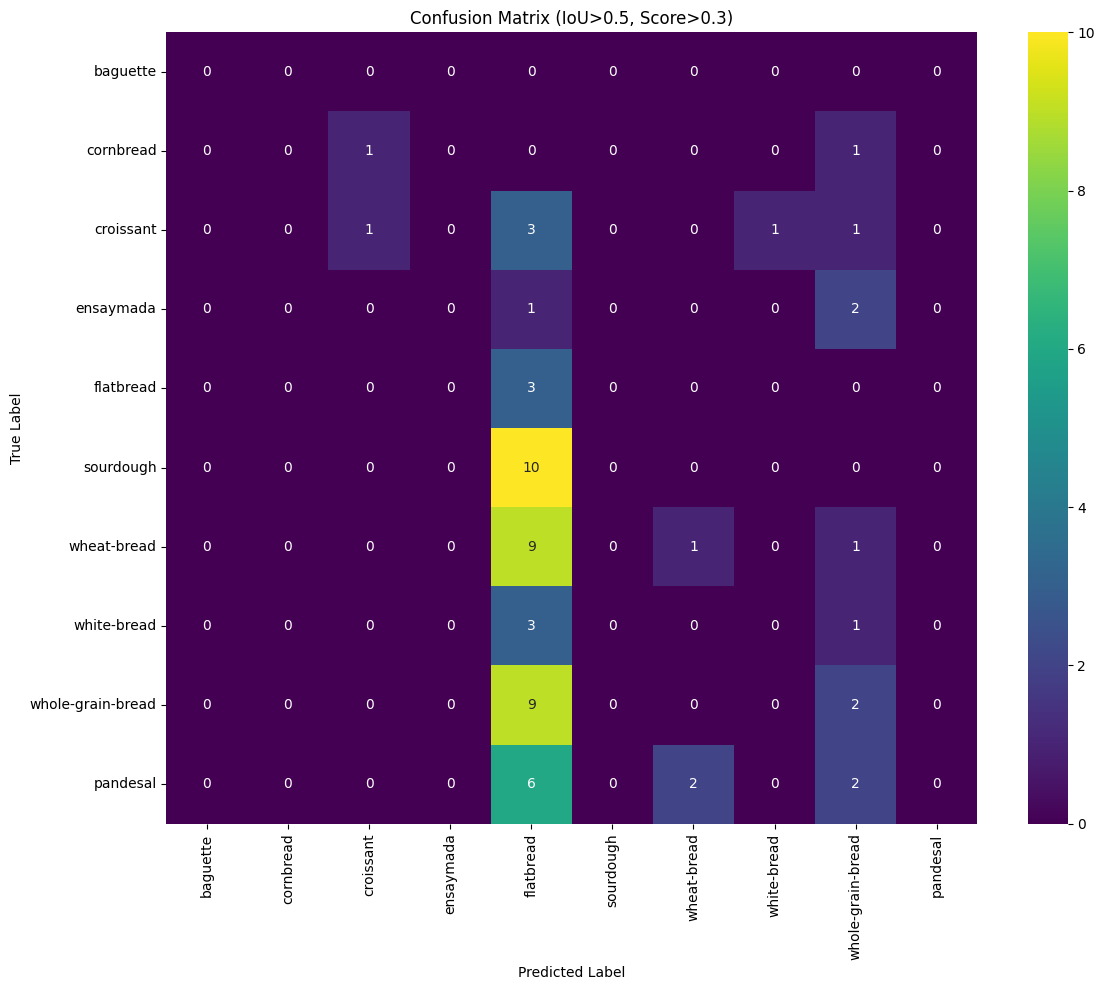

>>> Confusion matrix disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\post_training_reports\confusion_matrix.png
>>> PR curves disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\post_training_reports\pr_curves


In [9]:
# ===================================================================
# SEL 8: FUNGSI EVALUASI KUSTOM (DENGAN PERBAIKAN TIPE DATA TENSOR)
# ===================================================================

from mmdet.registry import DATASETS

def compute_iou_matrix(boxes1, boxes2):
    # ... (fungsi ini tidak berubah)
    if boxes1.size == 0 or boxes2.size == 0: return np.zeros((boxes1.shape[0], boxes2.shape[0]), dtype=np.float32)
    x11, y11, x12, y12 = boxes1[:,0], boxes1[:,1], boxes1[:,2], boxes1[:,3]
    x21, y21, x22, y22 = boxes2[:,0], boxes2[:,1], boxes2[:,2], boxes2[:,3]
    inter_x1 = np.maximum(x11[:, None], x21[None, :]); inter_y1 = np.maximum(y11[:, None], y21[None, :])
    inter_x2 = np.minimum(x12[:, None], x22[None, :]); inter_y2 = np.minimum(y12[:, None], y22[None, :])
    inter_w = np.maximum(0, inter_x2 - inter_x1); inter_h = np.maximum(0, inter_y2 - inter_y1)
    inter = inter_w * inter_h
    area1 = (x12 - x11) * (y12 - y11); area2 = (x22 - x21) * (y22 - y21)
    union = area1[:, None] + area2[None, :] - inter
    return np.where(union > 0, inter / union, 0.0)

def greedy_match(iou_mat, iou_thr=0.5):
    # ... (fungsi ini tidak berubah)
    matches = []; gt_used, pred_used = set(), set()
    if iou_mat.size == 0: return matches
    pairs = sorted([(i, j, iou_mat[i, j]) for i in range(iou_mat.shape[0]) for j in range(iou_mat.shape[1])], key=lambda x: x[2], reverse=True)
    for i, j, iou in pairs:
        if iou < iou_thr: break
        if i in gt_used or j in pred_used: continue
        gt_used.add(i); pred_used.add(j); matches.append((i, j))
    return matches

def evaluate_confusion_pr(model, dataset, output_dir, classes, device, score_thr=0.3, iou_thr=0.5):
    print(f"\n>>> Memulai evaluasi kustom (Score Thr: {score_thr}, IoU Thr: {iou_thr})...")
    n_classes = len(classes)
    conf_mat = np.zeros((n_classes, n_classes), dtype=np.int32)
    per_class_counts = {'TP': np.zeros(n_classes, dtype=np.int32), 'FP': np.zeros(n_classes, dtype=np.int32), 'FN': np.zeros(n_classes, dtype=np.int32)}
    pr_store = {c: {'scores': [], 'match': []} for c in range(n_classes)}

    pipeline = Compose(cfg.val_dataloader.dataset.pipeline)

    with open(filtered_valid_ann, 'r') as f: val_data = json.load(f)
    img_id_to_anns = {}
    for ann in val_data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_id_to_anns: img_id_to_anns[img_id] = []
        img_id_to_anns[img_id].append(ann)

    model.eval()
    with torch.no_grad():
      for img_info in tqdm(val_data['images'], desc="Mengevaluasi gambar"):
          gt_anns = img_id_to_anns.get(img_info['id'], [])
          gt_bboxes = np.array([ann['bbox'] for ann in gt_anns], dtype=np.float32)
          if gt_bboxes.shape[0] > 0:
              gt_bboxes[:, 2] += gt_bboxes[:, 0]
              gt_bboxes[:, 3] += gt_bboxes[:, 1]
          gt_labels = np.array([ann['category_id'] for ann in gt_anns], dtype=np.int64)

          img_path = os.path.join(DATASET_ROOT, 'valid', img_info['file_name'])
          data_info = {'img_path': img_path, 'img_id': 0}
          processed_data = pipeline(data_info)
          
          input_tensor = processed_data['inputs']
          
          # --- PERBAIKAN UTAMA ADA DI SINI ---
          # Konversi tipe data ke float, tambahkan dimensi batch, dan pindahkan ke device
          batched_input = input_tensor.float().unsqueeze(0).to(device)
          # --- AKHIR PERBAIKAN ---

          data_samples_list = [processed_data['data_samples']]
          results_list = model.predict(batched_input, data_samples_list)
          
          pred = results_list[0].pred_instances
          keep = pred.scores >= score_thr
          pred_bboxes, pred_scores, pred_labels = pred.bboxes[keep].cpu().numpy(), pred.scores[keep].cpu().numpy(), pred.labels[keep].cpu().numpy()

          iou_mat = compute_iou_matrix(gt_bboxes, pred_bboxes)
          matches = greedy_match(iou_mat, iou_thr=iou_thr)
          matched_gt, matched_pred = {m[0] for m in matches}, {m[1] for m in matches}

          for gi, pj in matches:
              gt_c, pd_c = int(gt_labels[gi]), int(pred_labels[pj])
              if gt_c == pd_c:
                  per_class_counts['TP'][pd_c] += 1
                  pr_store[pd_c]['scores'].append(float(pred_scores[pj]))
                  pr_store[pd_c]['match'].append(1)
              conf_mat[gt_c, pd_c] += 1

          for j, pd_c_int in enumerate(pred_labels.astype(int)):
              if j not in matched_pred:
                  per_class_counts['FP'][pd_c_int] += 1
                  pr_store[pd_c_int]['scores'].append(float(pred_scores[j]))
                  pr_store[pd_c_int]['match'].append(0)

          for i, gt_c_int in enumerate(gt_labels.astype(int)):
              if i not in matched_gt:
                  per_class_counts['FN'][gt_c_int] += 1
    
    # Sisa fungsi tidak berubah
    eps = 1e-12
    prec = per_class_counts['TP'] / (per_class_counts['TP'] + per_class_counts['FP'] + eps)
    rec  = per_class_counts['TP'] / (per_class_counts['TP'] + per_class_counts['FN'] + eps)
    f1   = 2 * prec * rec / (prec + rec + eps)
    lines = ["KELAS,TP,FP,FN,Precision,Recall,F1"]
    for c, name in enumerate(classes):
        lines.append(f"{name},{per_class_counts['TP'][c]},{per_class_counts['FP'][c]},{per_class_counts['FN'][c]},"
                     f"{prec[c]:.4f},{rec[c]:.4f},{f1[c]:.4f}")
    per_class_txt_path = os.path.join(output_dir, "per_class_metrics.csv")
    with open(per_class_txt_path, "w") as f: f.write("\n".join(lines))
    print(f">>> Metrik per kelas disimpan di: {per_class_txt_path}")
    fig_cm = plt.figure(figsize=(12, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='viridis', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix (IoU>{iou_thr}, Score>{score_thr})"); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.tight_layout()
    cm_path = os.path.join(output_dir, "confusion_matrix.png"); fig_cm.savefig(cm_path, dpi=200); plt.show()
    print(f">>> Confusion matrix disimpan di: {cm_path}")
    pr_curve_dir = os.path.join(output_dir, 'pr_curves')
    os.makedirs(pr_curve_dir, exist_ok=True)
    for c, class_name in enumerate(classes):
        scores, match = np.array(pr_store[c]['scores']), np.array(pr_store[c]['match'])
        if scores.size == 0: continue
        order = np.argsort(-scores); scores, match = scores[order], match[order]
        tp_cum, fp_cum = np.cumsum(match), np.cumsum(1 - match)
        precision = tp_cum / np.maximum(tp_cum + fp_cum, 1)
        total_pos = per_class_counts['TP'][c] + per_class_counts['FN'][c]
        recall = tp_cum / max(total_pos, 1) if total_pos > 0 else np.zeros_like(tp_cum)
        fig_pr = plt.figure(); plt.plot(recall, precision, '-'); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR Curve - {class_name}"); plt.grid(); plt.xlim(-0.05, 1.05); plt.ylim(-0.05, 1.05)
        pr_path = os.path.join(pr_curve_dir, f"pr_curve_{c:02d}_{class_name.replace(' ','_')}.png"); fig_pr.savefig(pr_path, dpi=200, bbox_inches='tight'); plt.close(fig_pr)
    print(f">>> PR curves disimpan di: {pr_curve_dir}")

if best_checkpoint_path:
    model = MODELS.build(cfg.model)
    checkpoint = torch.load(best_checkpoint_path, map_location='cpu', weights_only=False)
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    val_dataset = DATASETS.build(cfg.val_dataloader.dataset)
    
    evaluate_confusion_pr(model, val_dataset, REPORT_DIR, classes=CLASSES_TO_USE, device=device, score_thr=0.3, iou_thr=0.5)
else:
    print("\nEvaluasi kustom dilewati karena tidak ada checkpoint terbaik.")

In [10]:
# ===================================================================
# SEL 9: INFERENSI PADA GAMBAR ACAK & RINGKASAN DETEKSI (FOLDER RAPI)
# ===================================================================

# Pastikan variabel latest_run_dir dan best_checkpoint_path dari SEL 6 sudah ada
if 'latest_run_dir' in locals() and latest_run_dir and best_checkpoint_path:
    print("\n>>> Melakukan inferensi pada beberapa gambar validasi acak...")
    
    # --- PERBAIKAN: Buat folder inferensi di dalam direktori run terbaru ---
    INFERENCE_DIR = os.path.join(latest_run_dir, 'inference_results')
    os.makedirs(INFERENCE_DIR, exist_ok=True)
    print(f"Hasil inferensi akan disimpan di: {INFERENCE_DIR}")
    
    visualizer = DetLocalVisualizer(vis_backends=[dict(type='LocalVisBackend')], name='visualizer')
    visualizer.dataset_meta = cfg.val_dataloader.dataset.metainfo

    with open(filtered_valid_ann, 'r') as f: val_data = json.load(f)
    num_samples = min(5, len(val_data['images']))
    random_samples = random.sample(val_data['images'], k=num_samples)

    # Definisikan device dan pindahkan model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()

    with torch.no_grad():
        for i, img_info in enumerate(random_samples):
            img_path = os.path.join(DATASET_ROOT, 'valid', img_info['file_name'])
            original_image = mmcv.imread(img_path)
            
            # Siapkan data untuk inferensi manual
            pipeline = Compose(test_pipeline)
            data_info = {'img_path': img_path, 'img_id': 0}
            processed_data = pipeline(data_info)
            
            batched_input = processed_data['inputs'].float().unsqueeze(0).to(device)
            data_samples_list = [processed_data['data_samples']]

            results_list = model.predict(batched_input, data_samples_list)
            
            # Hitung Ringkasan
            pred_instances = results_list[0].pred_instances
            score_thr = 0.3 # Anda bisa menaikkan ini jika terlalu banyak deteksi
            keep_indices = pred_instances.scores >= score_thr
            labels_kept = pred_instances.labels[keep_indices].cpu().numpy()
            class_names = visualizer.dataset_meta['classes']
            counts = {name: int((labels_kept == i).sum()) for i, name in enumerate(class_names)}
            total_detected = int(keep_indices.sum())

            # Simpan Ringkasan ke Teks
            summary_txt_path = os.path.join(INFERENCE_DIR, f"summary_img_{img_info['id']}.txt")
            with open(summary_txt_path, "w") as f:
                f.write(f"Hasil Deteksi pada: {os.path.basename(img_path)}\n")
                f.write(f"Score Threshold: {score_thr}\n" + "="*30 + "\n")
                for class_name, count in counts.items():
                    if count > 0: f.write(f"{class_name}: {count}\n")
                f.write("="*30 + f"\nTOTAL TERDETEKSI: {total_detected}\n")
            print(f"Ringkasan deteksi disimpan di: {summary_txt_path}")

            # Simpan Visualisasi
            output_filename = f"visualization_img_{img_info['id']}.jpg"
            output_path = os.path.join(INFERENCE_DIR, output_filename)
            visualizer.add_datasample(
                name=f'prediction_{i}', image=original_image,
                data_sample=results_list[0], draw_gt=False,
                out_file=output_path, pred_score_thr=score_thr)
            print(f"Visualisasi disimpan di: {output_path}\n")

    print("\nProses visualisasi selesai.")
else:
    print("\nInferensi dilewati karena tidak ada direktori run/checkpoint yang valid.")


>>> Melakukan inferensi pada beberapa gambar validasi acak...
Hasil inferensi akan disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results
Ringkasan deteksi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\summary_img_160.txt


c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmengine\visualization\visualizer.py:760: UserWarning: Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(
c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmengine\visualization\visualizer.py:831: UserWarning: Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(
c:\Users\Stevenstven\anaconda3\envs\roti_env\lib\site-packages\mmengine\visualization\visualizer.py:508: UserWarning: Warning: The text is out of bounds, the drawn text may not be in the image
  warnings.warn(


Visualisasi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\visualization_img_160.jpg

Ringkasan deteksi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\summary_img_109.txt
Visualisasi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\visualization_img_109.jpg

Ringkasan deteksi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\summary_img_326.txt
Visualisasi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\visualization_img_326.jpg

Ringkasan deteksi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\summary_img_161.txt
Visualisasi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\visualization_img_161.jpg

Ringkasan deteksi disimpan di: outputs/BBreadDetector_RetinaNet_ResNet50\20251116_020625\inference_results\